<a href="https://colab.research.google.com/github/haidershoaib98/T-GCN-Info-Networks-Project/blob/main/5414_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class SupervisedForecastTask(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        regressor="linear",
        loss="mse",
        pre_len: int = 3,
        learning_rate: float = 1e-3,
        weight_decay: float = 1.5e-3,
        feat_max_val: float = 1.0,
        **kwargs
    ):
        super(SupervisedForecastTask, self).__init__()
        self.save_hyperparameters()
        self.model = model
        self.regressor = (
            nn.Linear(
                self.model.hyperparameters.get("hidden_dim")
                or self.model.hyperparameters.get("output_dim"),
                self.hparams.pre_len,
            )
            if regressor == "linear"
            else regressor
        )
        self._loss = loss
        self.feat_max_val = feat_max_val

    def forward(self, x):
        # (batch_size, seq_len, num_nodes)
        batch_size, _, num_nodes = x.size()
        # (batch_size, num_nodes, hidden_dim)
        hidden = self.model(x)
        # (batch_size * num_nodes, hidden_dim)
        hidden = hidden.reshape((-1, hidden.size(2)))
        # (batch_size * num_nodes, pre_len)
        if self.regressor is not None:
            predictions = self.regressor(hidden)
        else:
            predictions = hidden
        predictions = predictions.reshape((batch_size, num_nodes, -1))
        return predictions

    def shared_step(self, batch, batch_idx):
        # (batch_size, seq_len/pre_len, num_nodes)
        x, y = batch
        num_nodes = x.size(2)
        predictions = self(x)
        predictions = predictions.transpose(1, 2).reshape((-1, num_nodes))
        y = y.reshape((-1, y.size(2)))
        return predictions, y

    def loss(self, inputs, targets):
        if self._loss == "mse":
            return F.mse_loss(inputs, targets)
        if self._loss == "mse_with_regularizer":
            return mse_with_regularizer_loss_func(inputs, targets, self)
        raise NameError("Loss not supported:", self._loss)

    def training_step(self, batch, batch_idx):
        predictions, y = self.shared_step(batch, batch_idx)
        loss = self.loss(predictions, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        predictions, y = self.shared_step(batch, batch_idx)
        predictions = predictions * self.feat_max_val
        y = y * self.feat_max_val
        loss = self.loss(predictions, y)
        rmse = torch.sqrt(torchmetrics.functional.mean_squared_error(predictions, y))
        mae = torchmetrics.functional.mean_absolute_error(predictions, y)
        accuracy = accuracy_func(predictions, y)
        r2 = r2_func(predictions, y)
        explained_variance = explained_variance_func(predictions, y)
        metrics = {
            "val_loss": loss,
            "RMSE": rmse,
            "MAE": mae,
            "accuracy": accuracy,
            "R2": r2,
            "ExplainedVar": explained_variance,
        }
        self.log_dict(metrics)
        return predictions.reshape(batch[1].size()), y.reshape(batch[1].size())

    def test_step(self, batch, batch_idx):
        pass

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
    
    @staticmethod
    def add_task_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--learning_rate", "--lr", type=float, default=1e-3)
        parser.add_argument("--weight_decay", "--wd", type=float, default=1.5e-3)
        parser.add_argument("--loss", type=str, default="mse")
        return parser

In [ ]:
class SpatioTemporalCSVDataModule(pl.LightningDataModule):
    def __init__(
        self,
        feat_path: str,
        adj_path: str,
        batch_size: int = 64,
        seq_len: int = 12,
        pre_len: int = 3,
        split_ratio: float = 0.8,
        normalize: bool = True,
        **kwargs
    ):
        super(SpatioTemporalCSVDataModule, self).__init__()
        self._feat_path = feat_path
        self._adj_path = adj_path
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.pre_len = pre_len
        self.split_ratio = split_ratio
        self.normalize = normalize
        self._feat = load_features(self._feat_path)
        self._feat_max_val = np.max(self._feat)
        self._adj = load_adjacency_matrix(self._adj_path)

    @staticmethod
    def add_data_specific_arguments(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--batch_size", type=int, default=32)
        parser.add_argument("--seq_len", type=int, default=12)
        parser.add_argument("--pre_len", type=int, default=3)
        parser.add_argument("--split_ratio", type=float, default=0.8)
        parser.add_argument("--normalize", type=bool, default=True)
        return parser

    def setup(self, stage: str = None):
        (
            self.train_dataset,
            self.val_dataset,
        ) = generate_torch_datasets(
            self._feat,
            self.seq_len,
            self.pre_len,
            split_ratio=self.split_ratio,
            normalize=self.normalize,
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=len(self.val_dataset))

    @property
    def feat_max_val(self):
        return self._feat_max_val

    @property
    def adj(self):
        return self._adj

In [ ]:
DATA_PATHS = {
    "shenzhen": {"feat": "data/sz_speed.csv", "adj": "data/sz_adj.csv"},
    "losloop": {"feat": "/content/drive/My Drive/TGCN-Reproduce/data/los_speed.csv", "adj": "/content/drive/My Drive/TGCN-Reproduce/data/los_adj.csv"},
}


def get_model(args, dm):
    model = TGCN(adj=dm.adj, hidden_dim=args.hidden_dim)
    return model


# def get_task(args, model, dm):
#     task = getattr(tasks, args.settings.capitalize() + "ForecastTask")(
#         model=model, feat_max_val=dm.feat_max_val, **vars(args)
#     )
#     return task


# def get_callbacks(args):
#     checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="train_loss")
#     plot_validation_predictions_callback = utils.callbacks.PlotValidationPredictionsCallback(monitor="train_loss")
#     callbacks = [
#         checkpoint_callback,
#         plot_validation_predictions_callback,
#     ]
#     return callbacks


def main_supervised(args):
    dm = SpatioTemporalCSVDataModule(
        feat_path=DATA_PATHS[args.data]["feat"], adj_path=DATA_PATHS[args.data]["adj"], **vars(args)
    )
    model = get_model(args, dm)
    task = get_task(args, model, dm)
    callbacks = get_callbacks(args)
    trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks)
    trainer.fit(task, dm)
    results = trainer.validate(datamodule=dm)
    return results


def main(args):
    rank_zero_info(vars(args))
    results = globals()["main_" + args.settings](args)
    return results


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser = pl.Trainer.add_argparse_args(parser)

    parser.add_argument(
        "--data", type=str, help="The name of the dataset", choices=("shenzhen", "losloop"), default="losloop"
    )
    parser.add_argument(
        "--model_name",
        type=str,
        help="The name of the model for spatiotemporal prediction",
        choices=("GCN", "GRU", "TGCN"),
        default="GCN",
    )
    parser.add_argument(
        "--settings",
        type=str,
        help="The type of settings, e.g. supervised learning",
        choices=("supervised",),
        default="supervised",
    )
    parser.add_argument("--log_path", type=str, default=None, help="Path to the output console log file")
    parser.add_argument("--send_email", "--email", action="store_true", help="Send email when finished")

    temp_args, _ = parser.parse_known_args()

    # parser = getattr(utils.data, temp_args.settings.capitalize() + "DataModule").add_data_specific_arguments(parser)
    # parser = getattr(models, temp_args.model_name).add_model_specific_arguments(parser)
    # parser = getattr(tasks, temp_args.settings.capitalize() + "ForecastTask").add_task_specific_arguments(parser)

    # args = parser.parse_args()
    # utils.logging.format_logger(pl._logger)
    # if args.log_path is not None:
    #     utils.logging.output_logger_to_file(pl._logger, args.log_path)

    # try:
    #     results = main(args)
    # except:  # noqa: E722
    #     traceback.print_exc()
    #     if args.send_email:
    #         tb = traceback.format_exc()
    #         subject = "[Email Bot][❌] " + "-".join([args.settings, args.model_name, args.data])
    #         utils.email.send_email(tb, subject)
    #     exit(-1)

    # if args.send_email:
    #     subject = "[Email Bot][✅] " + "-".join([args.settings, args.model_name, args.data])
    #     utils.email.send_experiment_results_email(args, results, subject=subject)

# Installations

In [ ]:
!apt install libspatialindex-dev
!pip install osmnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
import pytorch_lightning as pl

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-aitg1xow
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-aitg1xow
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 829 kB 5.4 MB/s 
     |████████████████████████████████| 132 kB 41.5 MB/s 
     |████████████████████████████████| 329 kB 49.9 MB/s 
     |████████████████████████████████| 596 kB 35.1 MB/s 
     |████████████████████████████████| 1.1 MB 31.7 MB/s 
     |████████████████████████████████| 271 kB 43.5 MB/s 
     |████████████████████████████████| 192 kB 47.1 MB/s 
     |████████████████████████████████| 160 kB 42.6 MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_lightning-1.6.0.dev0-py3-none-any.whl size=519658 sha256=7a0f5362553280a1568a26ae1e1d6

# Setup

In [ ]:
pip install --upgrade tables

     |████████████████████████████████| 4.3 MB 5.2 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [ ]:
# Import Python libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
import h5py
import pickle

In [ ]:
# Import Python libraries
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
import h5py
import pickle

ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Haider's Drive

In [ ]:
# METR-LA
f = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/metr-la.h5')
f_adj = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/adj_mx.pkl')

# PEMS-BAY
f1 = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/pems-bay.h5')
f1_adj = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/adj_mx_bay.pkl')

Abdul Hamid's Drive

In [ ]:
# METR-LA
f = pd.read_hdf('/content/drive/My Drive/York/5414/Project/metr-la.h5')
# f_adj = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/adj_mx.pkl')

# # PEMS-BAY
# f1 = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/pems-bay.h5')
# f1_adj = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/adj_mx_bay.pkl')

FileNotFoundError: ignored

make a small version of the time series metr speed

In [ ]:
print(f.shape)
# metr_adj_frame = pd.DataFrame(f_adj)
metr_speed = pd.DataFrame(f)
# meter_adj_all = metr_adj_frame.to_numpy()
metr_speed_array = metr_speed.to_numpy()
metr_speed_array_small = metr_speed_array[:1000,:]

(34272, 207)


In [ ]:
metr_speed.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,767471,716339,773906,765273,716331,771667,716337,769953,769402,769403,769819,769405,716941,717578,716960,717804,767572,767573,773012,773013,764424,769388,716328,717819,769941,760987,718204,718045,769418,...,717582,717583,717580,716949,717587,772178,717585,716939,768469,764101,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,771673,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-03-01 00:00:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,55.500000,66.500000,64.250000,68.500000,60.375000,67.500000,37.75,63.125000,59.750000,62.125000,67.250000,41.250000,54.625000,58.125000,65.125000,64.250000,61.250000,62.750000,66.875000,47.375000,57.000000,67.750000,65.125,66.875000,64.000000,62.000000,64.375,60.750000,60.750,62.375000,...,68.250000,62.000000,64.500000,58.375000,64.500000,63.625000,63.750000,53.625000,69.875000,64.750000,62.375000,64.750000,52.125000,61.625000,63.000000,67.142857,67.625000,63.875000,63.125000,63.375000,64.125000,66.875000,69.875,67.750000,62.000000,66.750000,57.625000,52.625000,69.000000,43.500000,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
2012-03-01 00:05:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,58.777778,58.444444,66.444444,65.444444,56.111111,65.444444,39.00,63.777778,63.111111,66.111111,65.777778,56.777778,50.777778,56.222222,66.888889,54.444444,67.888889,61.555556,67.555556,46.777778,67.777778,67.888889,68.000,67.444444,66.444444,67.222222,63.000,64.333333,64.000,61.888889,...,66.777778,66.555556,67.333333,55.333333,66.555556,66.555556,65.777778,59.888889,66.888889,67.444444,62.222222,62.222222,52.333333,47.666667,67.111111,64.500000,69.111111,63.888889,60.444444,65.777778,63.888889,69.333333,63.000,67.666667,67.333333,66.666667,65.777778,51.666667,69.111111,39.888889,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875
2012-03-01 00:10:00,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500,64.250,63.875000,65.375000,61.375000,62.375000,64.750000,65.250000,61.875000,67.875000,35.25,63.875000,35.625000,65.000000,69.125000,49.125000,55.625000,59.125000,67.875000,63.125000,63.000000,64.500000,59.000000,47.750000,61.571429,66.500000,68.500,65.000000,66.250000,51.250000,63.875,64.875000,65.625,64.625000,...,64.000000,67.375000,65.250000,58.125000,64.625000,67.375000,66.750000,56.000000,68.750000,65.625000,61.000000,63.500000,56.125000,61.375000,64.125000,66.000000,68.625000,67.250000,64.000000,66.875000,65.000000,65.500000,54.875,68.750000,67.375000,65.750000,56.250000,49.375000,67.250000,38.250000,44.125000,69.000,56.500000,59.250000,68.125,62.500000,65.625000,61.375000,69.857143,62.000
2012-03-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
2012-03-01 00:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.0000

In [ ]:
print(metr_speed_array.shape)
print(metr_speed_array_small.shape)

(34272, 207)
(1000, 207)


In [ ]:
# METR setup
print(f.shape)
metr_adj_frame = pd.DataFrame(f_adj)
metr_speed = pd.DataFrame(f)
meter_adj_all = metr_adj_frame.to_numpy()
metr_speed_array = metr_speed.to_numpy()

sensor_id_metr = meter_adj_all[0]
print(sensor_id_metr.shape)
adj_metr = np.vstack(meter_adj_all[2])
print(adj_metr.shape)

print(metr_speed_array.shape)
metr_adj_frame.head()

(34272, 207)
(207,)
(207, 207)
(34272, 207)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206
0,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,767471,716339,773906,765273,716331,771667,716337,769953,769402,769403,769819,769405,716941,717578,716960,717804,767572,767573,773012,773013,764424,769388,716328,717819,769941,760987,718204,718045,769418,...,717582,717583,717580,716949,717587,772178,717585,716939,768469,764101,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,771673,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
1,717099,773869,767541,767542,717447,717446,717445,773062,767053,737529,717816,765604,767471,716339,772596,765273,716331,771667,716337,769953,769402,769403,769819,769405,769345,716960,717804,767572,767573,773012,773013,764424,764101,769388,716328,717819,769941,760987,718204,718045,...,717582,717583,717580,716949,717587,772178,717585,716939,768469,765182,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,765265,772167,718141,774204,767523,717590,717592,717595,772168,769372,769373
2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.3909554, 0.0, 0.0, 0.0, 0.0, 0.39...","[0.0, 0.7174379, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.63372165, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.62646437, 1.0, 0.0, 0.135196...","[0.0, 0.0, 0.0, 0.8948124, 0.36143157, 1.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.484031, 0.0, 0.0, 0.0, ...","[0.26093593, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19214275, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.11012548, 0.145012...","[0.0, 0.0, 0.0, 0.0, 0.106083035, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.17942527, 0.5831709, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.95091635...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.1198716, 0.0, 0.20515546, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5190026, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.27717918, 0.0, 0.5278345, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14527823, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
# PEMS setup
print(f1.shape)
pems_adj_frame = pd.DataFrame(f1_adj)
pems_speed = pd.DataFrame(f1)
pems_adj_all = pems_adj_frame.to_numpy()
pems_speed_array = pems_speed.to_numpy()

sensor_id_pems = pems_adj_all[0]
print(sensor_id_pems.shape)
adj_pems = np.vstack(pems_adj_all[2])
print(adj_pems.shape)

print(pems_speed_array.shape)
pems_adj_frame.head()

(52116, 325)
(325,)
(325, 325)
(52116, 325)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324
0,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,400073,400084,400085,400088,400096,400097,400100,400104,400109,400122,400147,400148,400149,400158,400160,400168,400172,400174,400178,400185,400201,400206,400209,400213,400221,400222,400227,400236,400238,400240,...,407207,407321,407323,407325,407328,407331,407332,407335,407336,407337,407339,407341,407342,407344,407348,407352,407359,407360,407361,407364,407367,407370,407372,407373,407374,407710,407711,408907,408911,409524,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
1,401391,409528,407157,401014,401948,407176,401129,407174,401154,401606,400479,401997,407153,400227,401495,400222,400221,407348,403406,400700,400149,400148,400147,401567,400677,402285,400709,402283,400673,400904,401845,400869,407184,401846,407180,407181,402361,402360,402363,400863,...,404553,408911,400799,400464,407172,400794,400792,400461,400790,400508,400717,400714,400715,401597,400713,400668,407150,400158,401611,400664,400665,407177,400911,400394,403402,408907,400995,400996,401327,403401,403409,401541,402372,400586,402370,402371,404554,400582,400581,407352
2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.13655277, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.6148081, 0.0, 1.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.23919003, 0.0, 1.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.6905352, 0.0, 0.40531704, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.4606583, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.2544442, 0.0, 0.10175049, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.6952649, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10654369...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

# Network Analysis

In [ ]:
sensor_loc_metr = pd.read_csv('/content/drive/My Drive/Colab Notebooks/graph_sensor_locations.csv')

In [ ]:
sensors_array_metr = sensor_loc_metr.to_numpy()
sensor_nums_metr = list(sensors_array_metr.T[0])
sensor_nums_metr = [int(i) for i in sensor_nums_metr]
sensor_id_list_metr = list(sensors_array_metr.T[1])
sensor_id_list_metr = [int(i) for i in sensor_id_list_metr]
zip_iterator_metr = zip(sensor_nums_metr, sensor_id_list_metr)
sensor_dictionary_metr = dict(zip_iterator_metr)
print(sensor_dictionary_metr)

{0: 773869, 1: 767541, 2: 767542, 3: 717447, 4: 717446, 5: 717445, 6: 773062, 7: 767620, 8: 737529, 9: 717816, 10: 765604, 11: 767471, 12: 716339, 13: 773906, 14: 765273, 15: 716331, 16: 771667, 17: 716337, 18: 769953, 19: 769402, 20: 769403, 21: 769819, 22: 769405, 23: 716941, 24: 717578, 25: 716960, 26: 717804, 27: 767572, 28: 767573, 29: 773012, 30: 773013, 31: 764424, 32: 769388, 33: 716328, 34: 717819, 35: 769941, 36: 760987, 37: 718204, 38: 718045, 39: 769418, 40: 768066, 41: 772140, 42: 773927, 43: 760024, 44: 774012, 45: 774011, 46: 767609, 47: 769359, 48: 760650, 49: 716956, 50: 769831, 51: 761604, 52: 717495, 53: 716554, 54: 773953, 55: 767470, 56: 716955, 57: 764949, 58: 773954, 59: 767366, 60: 769444, 61: 773939, 62: 774067, 63: 769443, 64: 767750, 65: 767751, 66: 767610, 67: 773880, 68: 764766, 69: 717497, 70: 717490, 71: 717491, 72: 717492, 73: 717493, 74: 765176, 75: 717498, 76: 717499, 77: 765171, 78: 718064, 79: 718066, 80: 765164, 81: 769431, 82: 769430, 83: 717610, 8

In [ ]:
sensor_nums_pems = list(range(0, 325))
zip_iterator_pems = zip(sensor_nums_pems, sensor_id_pems)
sensor_dictionary_pems = dict(zip_iterator_pems)
print(sensor_dictionary_pems)

{0: '400001', 1: '400017', 2: '400030', 3: '400040', 4: '400045', 5: '400052', 6: '400057', 7: '400059', 8: '400065', 9: '400069', 10: '400073', 11: '400084', 12: '400085', 13: '400088', 14: '400096', 15: '400097', 16: '400100', 17: '400104', 18: '400109', 19: '400122', 20: '400147', 21: '400148', 22: '400149', 23: '400158', 24: '400160', 25: '400168', 26: '400172', 27: '400174', 28: '400178', 29: '400185', 30: '400201', 31: '400206', 32: '400209', 33: '400213', 34: '400221', 35: '400222', 36: '400227', 37: '400236', 38: '400238', 39: '400240', 40: '400246', 41: '400253', 42: '400257', 43: '400258', 44: '400268', 45: '400274', 46: '400278', 47: '400280', 48: '400292', 49: '400296', 50: '400298', 51: '400330', 52: '400336', 53: '400343', 54: '400353', 55: '400372', 56: '400394', 57: '400400', 58: '400414', 59: '400418', 60: '400429', 61: '400435', 62: '400436', 63: '400440', 64: '400449', 65: '400457', 66: '400461', 67: '400464', 68: '400479', 69: '400485', 70: '400499', 71: '400507', 7

Graph Creation

In [ ]:
road_network_metr = nx.convert_matrix.from_numpy_matrix(adj_metr)
road_network_metr = nx.relabel_nodes(road_network_metr, sensor_dictionary_metr)
print(road_network_metr)

Graph with 207 nodes and 1520 edges


In [ ]:
print(road_network_metr.edges.data())

[(773869, 773869, {'weight': 1.0}), (773869, 773906, {'weight': 0.2609359323978424}), (773869, 718204, {'weight': 0.5088465213775635}), (773869, 773927, {'weight': 0.13740046322345734}), (773869, 773953, {'weight': 0.440931499004364}), (773869, 773916, {'weight': 0.21944808959960938}), (773869, 717572, {'weight': 0.17156152427196503}), (773869, 718090, {'weight': 0.10258746147155762}), (773869, 718496, {'weight': 0.11251228302717209}), (773869, 773904, {'weight': 0.7216228246688843}), (773869, 761003, {'weight': 0.8777612447738647}), (773869, 774204, {'weight': 0.11980409175157547}), (773869, 760987, {'weight': 0.5190026164054871}), (773869, 773954, {'weight': 0.1077904999256134}), (773869, 773880, {'weight': 0.3004092574119568}), (773869, 717576, {'weight': 0.1364293247461319}), (773869, 717573, {'weight': 0.9417392611503601}), (773869, 717570, {'weight': 0.11017611622810364}), (773869, 718499, {'weight': 0.5301210880279541}), (767541, 767541, {'weight': 1.0}), (767541, 767542, {'weig

In [ ]:
road_network_pems = nx.convert_matrix.from_numpy_matrix(adj_pems)
road_network_pems = nx.relabel_nodes(road_network_pems, sensor_dictionary_pems)
print(road_network_pems)

Graph with 325 nodes and 2404 edges


In [ ]:
print(road_network_pems.edges.data())

[('400001', '400001', {'weight': 1.0}), ('400017', '400017', {'weight': 1.0}), ('400030', '400030', {'weight': 1.0}), ('400030', '400045', {'weight': 0.6148080825805664}), ('400030', '400122', {'weight': 0.6905351877212524}), ('400030', '400253', {'weight': 0.6264347434043884}), ('400030', '400508', {'weight': 0.7928969264030457}), ('400030', '400709', {'weight': 0.5657060742378235}), ('400030', '400723', {'weight': 0.32379841804504395}), ('400030', '401440', {'weight': 0.9921252131462097}), ('400030', '401560', {'weight': 0.4250558018684387}), ('400030', '402057', {'weight': 0.10129242390394211}), ('400030', '403225', {'weight': 0.8556345105171204}), ('400030', '403265', {'weight': 0.8465353846549988}), ('400030', '408911', {'weight': 0.1496298760175705}), ('400030', '400172', {'weight': 0.2544442117214203}), ('400030', '400479', {'weight': 0.9829184412956238}), ('400030', '400586', {'weight': 0.21418610215187073}), ('400030', '400971', {'weight': 0.8950150012969971}), ('400030', '401

In [ ]:
metr_gcc = road_network_metr.subgraph(max(nx.connected_components(road_network_metr), key=len))
pems_gcc = road_network_pems.subgraph(max(nx.connected_components(road_network_pems), key=len))
print(metr_gcc)
print(pems_gcc)

Graph with 206 nodes and 1519 edges
Graph with 319 nodes and 2398 edges


In [ ]:
def degree_dist(G):
  return [G.degree(n) for n in G.nodes()]

In [ ]:
def plot_dd(G_dd):
  mu, std = sp.norm.fit(G_dd)
  plt.figure(1)
  a = plt.hist(G_dd, density=True, rwidth=0.7)
  b = 0
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = sp.norm.pdf(x, mu, std)
  return a

In [ ]:
def degree_dist_log(G):
  degrees = sorted(dict(G.degree()).values(),reverse=True)
  a = plt.loglog(degrees,'-',marker='o')
  return a 

In [ ]:
def clustering_coefficient_dist(G):
  clust = nx.clustering(G)
  a = plt.hist(clust.values(), density=True, rwidth=0.7)
  return a

In [ ]:
def shortest_path_dist(G):
  fullList = []
  sp = nx.shortest_path_length(G, weight='weights')
  for item in sp:
    fullList = fullList + list(item[1].values())
  a = plt.hist(fullList, density=True, rwidth=0.7)
  return a

Plotting Degree Distributions

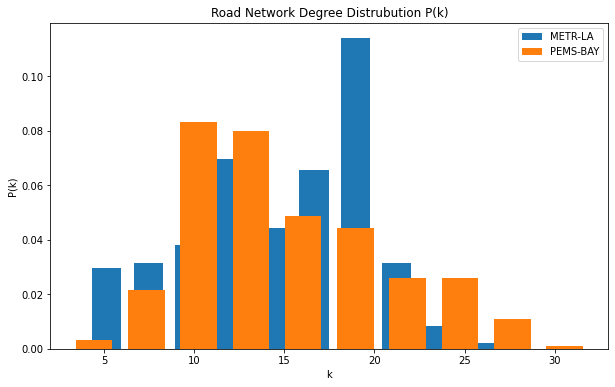

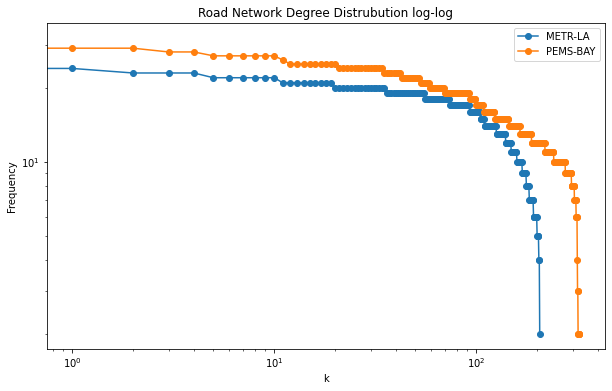

In [ ]:
plt.figure(1, figsize=(10, 6))
metr_deg = degree_dist(metr_gcc)
pems_deg = degree_dist(pems_gcc)
metr_dd_plot = plot_dd(metr_deg)
pems_dd_plot = plot_dd(pems_deg)
plt.title('Road Network Degree Distrubution P(k)')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend(('METR-LA', 'PEMS-BAY'), loc='upper right')
plt.show()

plt.figure(2, figsize=(10, 6))
metr_dd_plot_log = degree_dist_log(road_network_metr)
pems_dd_plot_log = degree_dist_log(road_network_pems)
plt.title('Road Network Degree Distrubution log-log')
plt.xlabel('k')
plt.ylabel('Frequency')
plt.legend(('METR-LA', 'PEMS-BAY'), loc='upper right')
plt.show()

In [ ]:
print(np.average(metr_deg))
print(np.average(pems_deg))

14.74757281553398
15.03448275862069


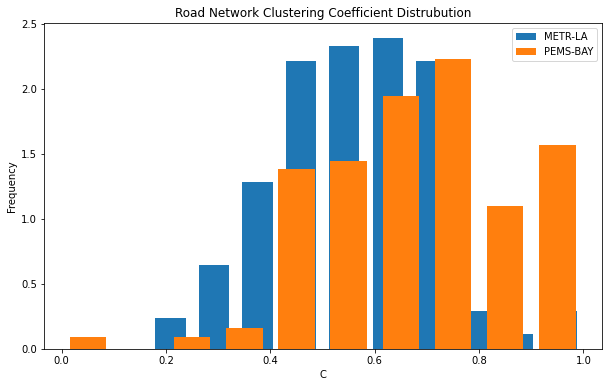

The global clustering coefficient for METR-LA is: 0.5510989624009818
The global clustering coefficient for PEMS-BAY is: 0.6494298859771954


In [ ]:
# Calculate and plot the clustering coefficient distrubutions
plt.figure(3, figsize=(10, 6))
metr_ccd = clustering_coefficient_dist(metr_gcc)
pems_ccd = clustering_coefficient_dist(pems_gcc)
plt.legend(('METR-LA', 'PEMS-BAY'), loc='upper right')
plt.title('Road Network Clustering Coefficient Distrubution')
plt.xlabel('C')
plt.ylabel('Frequency')
plt.show()

# Calculate the global clustering coefficient for each graph
metr_globalCC = nx.transitivity(metr_gcc)
pems_globalCC = nx.transitivity(pems_gcc)
print('The global clustering coefficient for METR-LA is: ' + str(metr_globalCC))
print('The global clustering coefficient for PEMS-BAY is: '+ str(pems_globalCC))

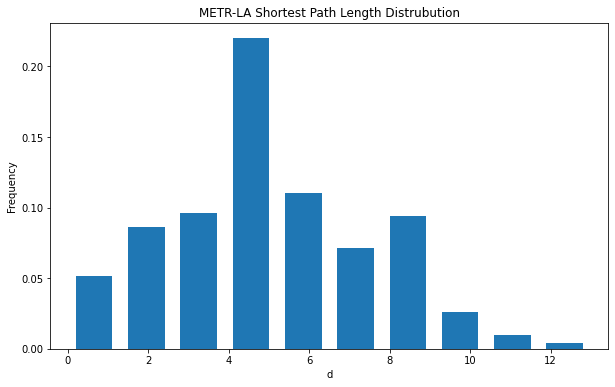

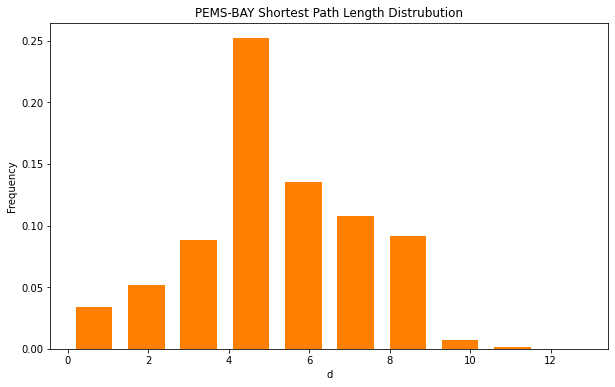

The average shortest path length for METR-LA is: 5.063746152024627
The average shortest path length for PEMS-BAY is: 5.161570158317068
The diameter of METR-LA is: 13
The diameter of PEMS-BAY is: 13


In [ ]:
# Calculate and plot the shortest path length distrubutions
plt.figure(4, figsize=(10, 6))
metr_spl = shortest_path_dist(metr_gcc)
plt.title('METR-LA Shortest Path Length Distrubution')
plt.xlabel('d')
plt.ylabel('Frequency')
plt.show()

a = []
sp = nx.shortest_path_length(pems_gcc)
for item in sp:
  a = a + list(item[1].values())
plt.figure(5, figsize=(10, 6))
plt.hist(a, density=True, rwidth=0.7, color='#FF8000')
plt.title('PEMS-BAY Shortest Path Length Distrubution')
plt.xlabel('d')
plt.ylabel('Frequency')
plt.show()

# Calculate the average shortest path length for each graph
metr_avg_pl = nx.average_shortest_path_length(metr_gcc)
pems_avg_pl = nx.average_shortest_path_length(pems_gcc)
print('The average shortest path length for METR-LA is: ' + str(metr_avg_pl))
print('The average shortest path length for PEMS-BAY is: ' + str(pems_avg_pl))

# Calculate the diameter of each graph
metr_diameter = nx.diameter(metr_gcc)
pems_diameter = nx.diameter(pems_gcc)
print('The diameter of METR-LA is: ' + str(metr_diameter))
print('The diameter of PEMS-BAY is: ' + str(pems_diameter))

# Node Rankings

Pagerank

In [ ]:
metr_pagerank = nx.pagerank(metr_gcc, weight='weights')
pems_pagerank = nx.pagerank(pems_gcc, weight='weights')

In [ ]:
pagerank_metr_ord = sorted(metr_pagerank.items(), key=lambda x:x[1])
pagerank_metr_ord.reverse()

pagerank_pems_ord = sorted(pems_pagerank.items(), key=lambda x:x[1])
pagerank_pems_ord.reverse()

print(pagerank_metr_ord[:50])
print(pagerank_pems_ord[:50])

[(771667, 0.008145586547522246), (767620, 0.0071020813792426135), (717502, 0.0069871098488337585), (762329, 0.0069346276867898), (769430, 0.006835667083267577), (773906, 0.006764332554586459), (769941, 0.006737485261630155), (717587, 0.006732232866059897), (765171, 0.00664179080983562), (767621, 0.006623148328908018), (767572, 0.006603953046083963), (764858, 0.006562094574957155), (772669, 0.0065280090032151985), (772167, 0.006448120892747145), (767573, 0.006394559276640661), (773869, 0.006385803917495369), (767470, 0.0063740977647339546), (717492, 0.006328290238969888), (760024, 0.006263283750472233), (767350, 0.006225336750963501), (771673, 0.006206920035207145), (769431, 0.006205782811610272), (773927, 0.00618003718016758), (717578, 0.006101757150889541), (718090, 0.00607863030691566), (773904, 0.006076452327838766), (767471, 0.006062510990473806), (768469, 0.0060286608329411535), (769346, 0.0060218588177997166), (764781, 0.006001597266856084), (718066, 0.005987387044801482), (71748

Edge Betweenness

In [ ]:
edge_between_metr = nx.edge_betweenness_centrality(metr_gcc, weight='weights')
edge_between_pems = nx.edge_betweenness_centrality(pems_gcc,weight='weights')

In [ ]:
edge_between_metr_ord = sorted(edge_between_metr.items(), key=lambda x:x[1])
edge_between_metr_ord.reverse()

edge_between_pems_ord = sorted(edge_between_pems.items(), key=lambda x:x[1])
edge_between_pems_ord.reverse()

print(edge_between_metr_ord[:20])
print(edge_between_pems_ord[:20])

[((773869, 717570), 0.08622420966559552), ((717493, 717570), 0.07699032709127318), ((717493, 769358), 0.07665091969066454), ((769430, 769358), 0.06206829557076413), ((773869, 718090), 0.05582469101247499), ((773927, 717585), 0.047026856526648064), ((773869, 773927), 0.046625781519892), ((773880, 761003), 0.04203725464282945), ((717491, 769346), 0.04062804101567268), ((717498, 769467), 0.039966546104050524), ((761599, 759591), 0.03809290324486595), ((769418, 717491), 0.03774824308061305), ((769443, 769346), 0.035816566209877124), ((769444, 769346), 0.035816566209877124), ((771667, 716953), 0.034472597909014815), ((773906, 774204), 0.034057483882847496), ((773906, 718496), 0.034057483882847496), ((764949, 717480), 0.03388663993206908), ((717099, 718090), 0.03272933032957114), ((773906, 761599), 0.03230388540018156)]
[(('402057', '402365'), 0.08971570766620515), (('401507', '401997'), 0.07219382945793651), (('400258', '402057'), 0.0581992565561463), (('401997', '402367'), 0.04575578859988

Remove top 10 edges and show Path Length Distribution

In [ ]:
temp_metr = nx.Graph(metr_gcc)
temp_metr.remove_edge(edge_between_metr_ord[0][0][0], edge_between_metr_ord[0][0][1])
temp_metr.remove_edge(edge_between_metr_ord[1][0][0], edge_between_metr_ord[1][0][1])
temp_metr.remove_edge(edge_between_metr_ord[2][0][0], edge_between_metr_ord[2][0][1])
temp_metr.remove_edge(edge_between_metr_ord[3][0][0], edge_between_metr_ord[3][0][1])
temp_metr.remove_edge(edge_between_metr_ord[4][0][0], edge_between_metr_ord[4][0][1])
temp_metr.remove_edge(edge_between_metr_ord[5][0][0], edge_between_metr_ord[5][0][1])
temp_metr.remove_edge(edge_between_metr_ord[6][0][0], edge_between_metr_ord[6][0][1])
temp_metr.remove_edge(edge_between_metr_ord[7][0][0], edge_between_metr_ord[7][0][1])
temp_metr.remove_edge(edge_between_metr_ord[8][0][0], edge_between_metr_ord[8][0][1])
temp_metr.remove_edge(edge_between_metr_ord[9][0][0], edge_between_metr_ord[9][0][1])

In [ ]:
temp_pem = nx.Graph(pems_gcc)
temp_pem.remove_edge(edge_between_pems_ord[0][0][0], edge_between_pems_ord[0][0][1])
temp_pem.remove_edge(edge_between_pems_ord[1][0][0], edge_between_pems_ord[1][0][1])
temp_pem.remove_edge(edge_between_pems_ord[2][0][0], edge_between_pems_ord[2][0][1])
temp_pem.remove_edge(edge_between_pems_ord[3][0][0], edge_between_pems_ord[3][0][1])
temp_pem.remove_edge(edge_between_pems_ord[4][0][0], edge_between_pems_ord[4][0][1])
temp_pem.remove_edge(edge_between_pems_ord[5][0][0], edge_between_pems_ord[5][0][1])
temp_pem.remove_edge(edge_between_pems_ord[6][0][0], edge_between_pems_ord[6][0][1])
temp_pem.remove_edge(edge_between_pems_ord[7][0][0], edge_between_pems_ord[7][0][1])
temp_pem.remove_edge(edge_between_pems_ord[8][0][0], edge_between_pems_ord[8][0][1])
temp_pem.remove_edge(edge_between_pems_ord[9][0][0], edge_between_pems_ord[9][0][1])

In [ ]:
print(metr_gcc)
print(temp_metr)

Graph with 206 nodes and 1519 edges
Graph with 206 nodes and 1509 edges


In [ ]:
print(pems_gcc)
print(temp_pem)

Graph with 319 nodes and 2398 edges
Graph with 319 nodes and 2388 edges


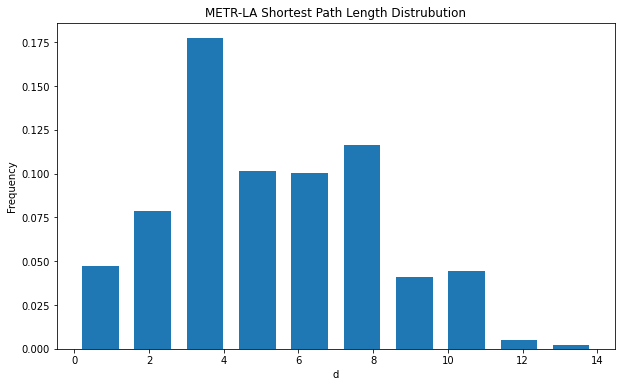

In [ ]:
plt.figure(6, figsize=(10, 6))
metr_spl = shortest_path_dist(temp_metr)
plt.title('METR-LA Shortest Path Length Distrubution')
plt.xlabel('d')
plt.ylabel('Frequency')
plt.show()

In [ ]:
metr_avg = nx.average_shortest_path_length(temp_metr)
print(metr_avg)

5.2168126923987685


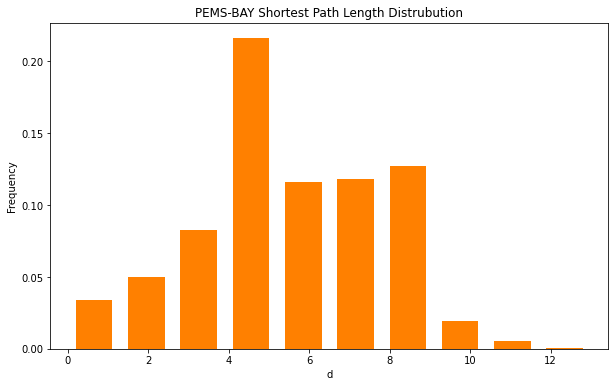

In [ ]:
a = []
sp = nx.shortest_path_length(temp_pem)
for item in sp:
  a = a + list(item[1].values())
plt.figure(7, figsize=(10, 6))
plt.hist(a, density=True, rwidth=0.7, color='#FF8000')
plt.title('PEMS-BAY Shortest Path Length Distrubution')
plt.xlabel('d')
plt.ylabel('Frequency')
plt.show()

In [ ]:
pem_avg = nx.average_shortest_path_length(temp_pem)
print(pem_avg)

5.47962382445141


# Community Detection

Girvin Newman Community Detection

In [ ]:
def fun(G):
    centrality = nx.edge_betweenness_centrality(G)
    return max(centrality, key=centrality.get)

In [ ]:
import itertools
comp = nx.algorithms.community.girvan_newman(metr_gcc)

In [ ]:
comp1 = nx.algorithms.community.girvan_newman(pems_gcc)

In [ ]:
metr_result = None
for communities in itertools.islice(comp, 10):
    metr_result = tuple(sorted(c) for c in communities)
    if len(metr_result) > 10:
        break

In [ ]:
pems_result = None
for communities in itertools.islice(comp1, 10):
    pems_result = tuple(sorted(c) for c in communities)
    if len(pems_result) > 10:
        break

In [ ]:
print(len(metr_result))
print(len(pems_result))

11
11


In [ ]:
print(metr_result)
print(pems_result)

([716554, 716968, 717572, 717573, 717576, 717578, 717580, 717582, 717583, 718090, 718204, 718379, 718499, 759772, 761003, 761599, 761604, 773869, 773904, 773906, 773916, 773927, 773953, 773954, 774067], [716953, 717099, 717585, 717587, 717590, 717592, 717595, 718064, 718066, 718072, 718076, 762329, 767454, 767455, 767470, 767471, 767494, 767495, 767509, 767523, 767541, 767542, 767554, 767572, 767573, 767585, 767620, 767621, 773974, 773975, 773995, 773996, 774011, 774012], [716337, 716339, 717446, 717447, 717450, 717452, 717453, 717456, 717458, 717459, 717460, 717461, 717462, 717463, 717465, 717466, 717468, 717469, 717472, 717473, 717480, 717481, 765164, 769372, 769373], [716328, 716331, 716939, 716941, 716942, 716943, 716949, 716951, 716955, 717445, 718045, 718371, 760650, 764853, 765182, 767750, 767751, 771667, 771673, 772513, 772669, 773012, 773013, 773023, 773024, 773062], [717499, 717502, 717504, 717508, 717510, 717513, 717816, 717818, 717819, 717821, 717823, 717825, 737529, 760024

In [ ]:
metr_list = []
for i in metr_result:
    metr_list.append(len(i))
metr_list.sort()
metr_list.reverse()
print(metr_list)

[37, 34, 33, 26, 25, 25, 9, 7, 6, 3, 1]


In [ ]:
pems_list = []
for i in pems_result:
    pems_list.append(len(i))
pems_list.sort()
pems_list.reverse()
print(pems_list)

[68, 63, 48, 38, 29, 20, 18, 17, 10, 6, 2]


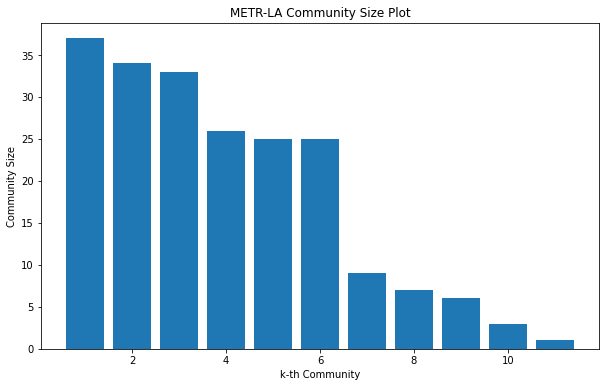

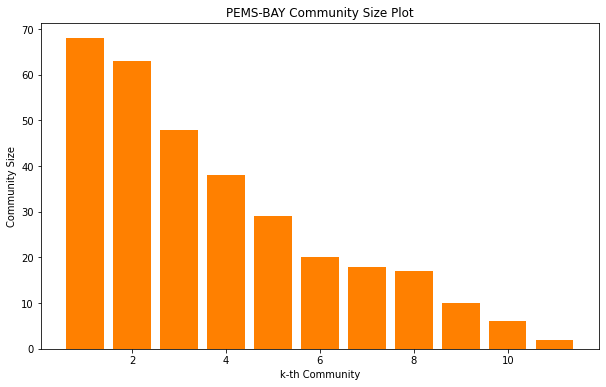

In [ ]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
plt.figure(6, figsize=(10, 6))
plt.bar(l, metr_list)
plt.xlabel('k-th Community')
plt.ylabel('Community Size')
plt.title('METR-LA Community Size Plot')
plt.show()

plt.figure(7, figsize=(10, 6))
plt.bar(l, pems_list, color='#FF8000')
plt.xlabel('k-th Community')
plt.ylabel('Community Size')
plt.title('PEMS-BAY Community Size Plot')
plt.show()

# Main

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
np.savetxt("metr_speed.csv", metr_speed_array_small, delimiter=",")

In [ ]:
!rm -rf T-GCN/

In [ ]:
# np.savetxt("metr_adj.csv", adj, delimiter=",")
# np.savetxt("metr_speed.csv", metr_speed_array, delimiter=",")

In [ ]:
! git clone https://github.com/lehaifeng/T-GCN.git # OG code

Cloning into 'T-GCN'...
remote: Enumerating objects: 731, done.
remote: Counting objects: 100% (391/391), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 731 (delta 203), reused 259 (delta 133), pack-reused 340
Receiving objects: 100% (731/731), 31.09 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (350/350), done.


In [ ]:
!git clone https://github.com/AbdulHamidDabboussi/T-GCN.git # our code

Cloning into 'T-GCN'...
remote: Enumerating objects: 760, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 760 (delta 92), reused 44 (delta 14), pack-reused 579
Receiving objects: 100% (760/760), 31.12 MiB | 17.73 MiB/s, done.
Resolving deltas: 100% (372/372), done.


In [ ]:
print(pl.__version__)

1.6.0dev


In [ ]:
!python T-GCN/T-GCN/T-GCN-PyTorch/main.py \
--model_name TGCN \
--max_epochs 3000 \
--learning_rate 0.001 \
--weight_decay 0 \
--batch_size 32 \
--hidden_dim 64 \
--loss mse_with_regularizer \
--settings supervised \
--gpus 1

Streaming output truncated to the last 5000 lines.
Validating: 0it [00:00, ?it/s]
Epoch 1342: 100% 26/26 [00:01<00:00, 19.45it/s, loss=85.7, v_num=0]
Epoch 1343:  77% 20/26 [00:00<00:00, 20.39it/s, loss=93.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1343: 100% 26/26 [00:01<00:00, 19.87it/s, loss=85.7, v_num=0]
Epoch 1344:  77% 20/26 [00:00<00:00, 20.14it/s, loss=93.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1344: 100% 26/26 [00:01<00:00, 19.68it/s, loss=85.7, v_num=0]
Epoch 1345:  77% 20/26 [00:01<00:00, 19.91it/s, loss=93.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1345: 100% 26/26 [00:01<00:00, 19.52it/s, loss=85.7, v_num=0]
Epoch 1346:  77% 20/26 [00:00<00:00, 20.11it/s, loss=93.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1346: 100% 26/26 [00:01<00:00, 19.43it/s, loss=85.7, v_num=0]
Epoch 1347:  77% 20/26 [00:00<00:00, 20.31it/s, loss=93.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1347: 100% 26/26 [00:01<00:00, 19.77it/s, loss=85.6, v_num=0]
Epoch 1348:  77

In [ ]:
!python T-GCN/T-GCN/T-GCN-PyTorch/main.py \
--model_name TGCN \
--max_epochs 3000 \
--learning_rate 0.0005 \
--weight_decay 0 \
--batch_size 32 \
--hidden_dim 64 \
--loss mse_with_regularizer \
--settings supervised \
--gpus 1

Streaming output truncated to the last 5000 lines.
Epoch 1344:  77% 20/26 [00:00<00:00, 20.18it/s, loss=97.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1344: 100% 26/26 [00:01<00:00, 19.72it/s, loss=89.7, v_num=0]
Epoch 1345:  77% 20/26 [00:00<00:00, 20.06it/s, loss=97.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1345: 100% 26/26 [00:01<00:00, 19.57it/s, loss=89.7, v_num=0]
Epoch 1346:  77% 20/26 [00:00<00:00, 20.19it/s, loss=97.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1346: 100% 26/26 [00:01<00:00, 19.68it/s, loss=89.7, v_num=0]
Epoch 1347:  77% 20/26 [00:00<00:00, 20.06it/s, loss=97.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1347: 100% 26/26 [00:01<00:00, 19.48it/s, loss=89.7, v_num=0]
Epoch 1348:  77% 20/26 [00:00<00:00, 20.24it/s, loss=97.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1348: 100% 26/26 [00:01<00:00, 19.75it/s, loss=89.7, v_num=0]
Epoch 1349:  77% 20/26 [00:00<00:00, 20.02it/s, loss=97.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1349: 100

In [ ]:
!python T-GCN/T-GCN/T-GCN-PyTorch/main.py \
--model_name TGCN \
--max_epochs 3000 \
--learning_rate 0.0001 \
--weight_decay 0 \
--batch_size 32 \
--hidden_dim 64 \
--loss mse_with_regularizer \
--settings supervised \
--gpus 1

Streaming output truncated to the last 5000 lines.
Epoch 1343:  77% 20/26 [00:00<00:00, 20.09it/s, loss=109, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1343: 100% 26/26 [00:01<00:00, 19.62it/s, loss=99.6, v_num=1]
Epoch 1344:  77% 20/26 [00:00<00:00, 20.09it/s, loss=109, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1344: 100% 26/26 [00:01<00:00, 19.56it/s, loss=99.6, v_num=1]
Epoch 1345:  77% 20/26 [00:00<00:00, 20.20it/s, loss=109, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1345: 100% 26/26 [00:01<00:00, 19.73it/s, loss=99.6, v_num=1]
Epoch 1346:  77% 20/26 [00:00<00:00, 20.15it/s, loss=109, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1346: 100% 26/26 [00:01<00:00, 19.71it/s, loss=99.6, v_num=1]
Epoch 1347:  77% 20/26 [00:00<00:00, 20.19it/s, loss=109, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1347: 100% 26/26 [00:01<00:00, 19.73it/s, loss=99.6, v_num=1]
Epoch 1348:  77% 20/26 [00:00<00:00, 20.24it/s, loss=109, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1348: 100

In [ ]:
!python T-GCN/T-GCN/T-GCN-PyTorch/main.py \
--model_name TGCN \
--max_epochs 3000 \
--learning_rate 0.005 \
--weight_decay 0 \
--batch_size 32 \
--hidden_dim 64 \
--loss mse_with_regularizer \
--settings supervised \
--gpus 1

Streaming output truncated to the last 5000 lines.
Epoch 1343: 100% 26/26 [00:01<00:00, 19.66it/s, loss=75.4, v_num=2]
Epoch 1344:  77% 20/26 [00:00<00:00, 20.12it/s, loss=83.5, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 1344: 100% 26/26 [00:01<00:00, 19.65it/s, loss=79.2, v_num=2]
Epoch 1345:  77% 20/26 [00:00<00:00, 20.11it/s, loss=84.4, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 1345: 100% 26/26 [00:01<00:00, 19.60it/s, loss=80.5, v_num=2]
Epoch 1346:  77% 20/26 [00:00<00:00, 20.35it/s, loss=84.5, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 1346: 100% 26/26 [00:01<00:00, 19.86it/s, loss=79.7, v_num=2]
Epoch 1347:  77% 20/26 [00:01<00:00, 19.84it/s, loss=84.9, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 1347: 100% 26/26 [00:01<00:00, 19.35it/s, loss=78.5, v_num=2]
Epoch 1348:  77% 20/26 [00:00<00:00, 20.29it/s, loss=80.6, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 1348: 100% 26/26 [00:01<00:00, 19.80it/s, loss=76, v_num=2]  
Epoch 1349:  77% 20/26 [00:01<00:00, 19.97it/s

In [ ]:
!python T-GCN/T-GCN/T-GCN-PyTorch/main.py \
--model_name TGCN \
--max_epochs 3000 \
--learning_rate 0.0001 \
--weight_decay 0 \
--batch_size 32 \
--hidden_dim 128 \
--loss mse_with_regularizer \
--settings supervised \
--gpus 1

Streaming output truncated to the last 5000 lines.
Epoch 1755: 100% 26/26 [00:02<00:00,  9.95it/s, loss=95.5, v_num=0]
Epoch 1756:  77% 20/26 [00:01<00:00, 10.25it/s, loss=104, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:   0% 0/1 [00:00<?, ?it/s]
Epoch 1756: 100% 26/26 [00:02<00:00,  9.96it/s, loss=95.5, v_num=0]
Epoch 1757:  77% 20/26 [00:01<00:00, 10.21it/s, loss=104, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:   0% 0/1 [00:00<?, ?it/s]
Epoch 1757: 100% 26/26 [00:02<00:00,  9.93it/s, loss=95.5, v_num=0]
Epoch 1758:  77% 20/26 [00:01<00:00, 10.16it/s, loss=104, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:   0% 0/1 [00:00<?, ?it/s]
Epoch 1758: 100% 26/26 [00:02<00:00,  9.91it/s, loss=95.5, v_num=0]
Epoch 1759:  77% 20/26 [00:01<00:00, 10.17it/s, loss=104, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:   0% 0/1 [00:00<?, ?it/s]
Epoch 1759: 100% 26/26 [00:02<00:00,  9.91it/s, loss=95.5, v_num=0]
Epoch 1760:  77% 20/26 [00:01<00:00, 10.20it/s, loss=104, v_n

In [ ]:
!python T-GCN/T-GCN/T-GCN-PyTorch/main.py \
--model_name TGCN \
--max_epochs 3000 \
--learning_rate 0.0001 \
--weight_decay 1.5e-3 \
--batch_size 32 \
--hidden_dim 64 \
--loss mse_with_regularizer \
--settings supervised \
--gpus 1

Streaming output truncated to the last 5000 lines.
Validating: 0it [00:00, ?it/s]
Epoch 1342: 100% 26/26 [00:01<00:00, 19.97it/s, loss=99.6, v_num=0]
Epoch 1343:  77% 20/26 [00:00<00:00, 20.56it/s, loss=109, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1343: 100% 26/26 [00:01<00:00, 20.00it/s, loss=99.6, v_num=0]
Epoch 1344:  77% 20/26 [00:00<00:00, 20.47it/s, loss=109, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1344: 100% 26/26 [00:01<00:00, 19.97it/s, loss=99.6, v_num=0]
Epoch 1345:  77% 20/26 [00:00<00:00, 20.53it/s, loss=109, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1345: 100% 26/26 [00:01<00:00, 20.04it/s, loss=99.6, v_num=0]
Epoch 1346:  77% 20/26 [00:00<00:00, 20.24it/s, loss=109, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1346: 100% 26/26 [00:01<00:00, 19.72it/s, loss=99.6, v_num=0]
Epoch 1347:  77% 20/26 [00:00<00:00, 20.53it/s, loss=109, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1347: 100% 26/26 [00:01<00:00, 19.92it/s, loss=99.6, v_num=0]
Epoch 1348:  77

In [ ]:
!python T-GCN/T-GCN/T-GCN-PyTorch/main.py \
--model_name TGCN \
--max_epochs 3000 \
--learning_rate 0.0001 \
--weight_decay 1e-4 \
--batch_size 32 \
--hidden_dim 64 \
--loss mse_with_regularizer \
--settings supervised \
--gpus 1

Streaming output truncated to the last 5000 lines.
Validating: 0it [00:00, ?it/s]
Epoch 1342: 100% 26/26 [00:01<00:00, 19.91it/s, loss=98.7, v_num=1]
Epoch 1343:  77% 20/26 [00:00<00:00, 20.61it/s, loss=108, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1343: 100% 26/26 [00:01<00:00, 20.02it/s, loss=98.7, v_num=1]
Epoch 1344:  77% 20/26 [00:00<00:00, 20.40it/s, loss=108, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1344: 100% 26/26 [00:01<00:00, 19.91it/s, loss=98.6, v_num=1]
Epoch 1345:  77% 20/26 [00:00<00:00, 20.64it/s, loss=108, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1345: 100% 26/26 [00:01<00:00, 20.04it/s, loss=98.6, v_num=1]
Epoch 1346:  77% 20/26 [00:00<00:00, 20.35it/s, loss=108, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1346: 100% 26/26 [00:01<00:00, 19.81it/s, loss=98.6, v_num=1]
Epoch 1347:  77% 20/26 [00:00<00:00, 20.53it/s, loss=108, v_num=1] 
Validating: 0it [00:00, ?it/s]
Epoch 1347: 100% 26/26 [00:01<00:00, 19.93it/s, loss=98.6, v_num=1]
Epoch 1348:  77